# Converting IRB Images

This notebook walks through converting [Jenoptik](https://www.jenoptik.com/) VarioCam infrared images (.irb format) into ASCII using a command line utility (Windows .exe application) and visualizing the results in python.

Notebook by Steven Pestana (spestana@uw.edu), 2019; _**irb2txt.exe** was provided by A. Echevarria (arnaldo@arnaldo3.com)_

---

In [1]:
import os
import pandas as pd
import numpy as np

import PIL
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

### 1) Converting IRB to ASCII:

Set path to irb2txt.exe:

In [2]:
exe_path = r'irb2txt'

Set path to .irb files to convert:

In [3]:
irb_path = r'.\example_images'

Run irb2txt:

In [4]:
! "{exe_path}\irb2txt.exe" "{irb_path}"

Processing .\example_images\AA082408.irb...
Processing .\example_images\AB082504.irb...
Processing .\example_images\AG082624.irb...


The infrared images are now stored as ASCII text in a tab-separated table of in the following format:

|ID | y-pixel | x-pixel | brightness temperature (F) |
|---|---|---|---|
|1     |1     |1     |-5.00085|
|2     |1     |2     |-5.31424|
|3     |1     |3     |-5.45352|
|**...**|**...**|**...**|**...**|



### 2) Viewing images in python

Look through the directory where we converted these files, and get a list of all of the .txt files (infrared images) we just created, as well as the corresponding .bmp files (visible images):

In [5]:
path = irb_path
files_dict = {}
for root, dirs_list, files_list in os.walk(path):
    for file_name in files_list:
        
        # Find filepaths for all .txt and their corresponding .bmp files
        if os.path.splitext(file_name)[-1] == '.txt':
            current_file = {str(os.path.splitext(file_name)[0]): 
                            {'ir_filepath':os.path.join(root, file_name),
                            'vis_filepath':os.path.join(root, os.path.splitext(file_name)[0]+'.bmp')}}
            files_dict.update(current_file)

# Make a list of the filenames we now have from this directory           
filenames = [filename for filename in files_dict.keys()]

Load one of the IR images we just converted:

In [6]:
# pick the ith image from the list
i = 2

# load this image
ir_image = pd.read_csv(files_dict[filenames[i]]['ir_filepath'], sep='\s+', header=None)

# add column headers
ir_image.columns = ['ID','y_pixel','x_pixel','brightness temperature']

# Take a look at the first few rows
ir_image.head()

,ID,y_pixel,x_pixel,brightness temperature
0,1,1,1,64.98651
1,2,1,2,64.90147
2,3,1,3,64.81644
3,4,1,4,64.71014
4,5,1,5,64.75266


Reformat the data into 2D arrays for plotting:

In [7]:
# Get the image dimensions in number of pixels, x and y
y_dim = ir_image.y_pixel.max()
x_dim = ir_image.x_pixel.max()
print('Reshaping to image dimensions of x={}, y={}'.format(x_dim,y_dim))

# Reshape the brightness temperature data into a numpy array of this shape:
tb_image_F = np.array(ir_image['brightness temperature']).reshape(y_dim,x_dim)
# Convert from degrees Fahrenheit to Kelvin:
tb_image = 273.15 + ((tb_image_F - 32) / 1.8)

Reshaping to image dimensions of x=640, y=480


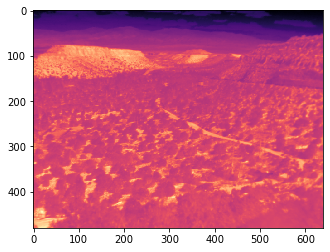

In [8]:
plt.imshow(tb_image, cmap='magma');

Now load the corresponding visible image to plot the two side by side.

In [9]:
# use PIL to load the .bmp file
vis_image = PIL.Image.open(files_dict[filenames[i]]['vis_filepath'])
print('Infrared image size: {}'.format(tb_image.T.shape))
print('Visible image size: {}'.format(vis_image.size))

Infrared image size: (640, 480)
Visible image size: (640, 512)


These images are of different sizes and have slightly different fields of view. We can crop and reshape the visible image to approximately the same field of view as the IR image:

In [10]:
# Set area to keep within the visible image, approximately the same FOV as the IR image
area = (70, 45, 605, 440) # I picked these values by sight alone
# Crop and reshape
cropped_img = vis_image.crop(area).resize(tb_image.T.shape)

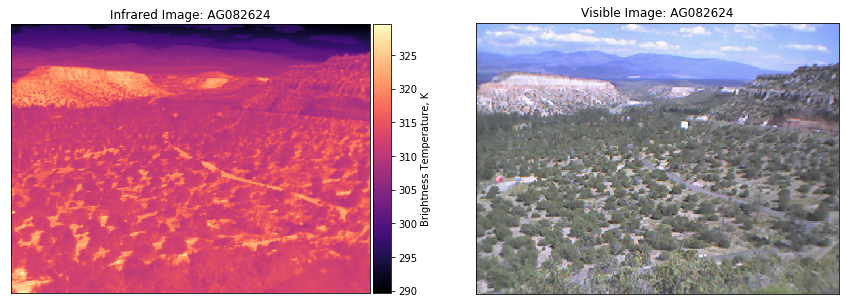

In [12]:
f, ax = plt.subplots(1,2,figsize=(15,5))

# Plot infrared image with colorbar showing brightness temperatures
ir = ax[0].imshow(tb_image, cmap='magma')
# Create colorbar
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(ir, cax=cax, orientation='vertical', label='Brightness Temperature, K')

# Plot visible image for context
vis = ax[1].imshow(cropped_img)

# Hide the x and y pixel image dimension axes in both images
ax[0].get_yaxis().set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# Set image titles
ax[0].set_title('Infrared Image: {}'.format(filenames[i]))
ax[1].set_title('Visible Image: {}'.format(filenames[i]));

plt.savefig('ir-vis-example-{}.jpg'.format(filenames[i]),dpi=200)